In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# read in csv 
df = pd.read_csv('data/df_final_2023_08_25')
# shape 
print("Shape: ", df.shape)

Shape:  (907485, 16)


In [10]:
print("Set the printing size of the pandas df: ")
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Set the printing size of the pandas df: 


In [11]:
print("Deleting the discontious SCC where period_index==-1")
print("Shape: ", df.shape)
df = df[df["period_index"] != -1]
print("Shape: ", df.shape)

Deleting the discontious SCC where period_index==-1
Shape:  (907485, 16)
Shape:  (671868, 16)


In [12]:
print("To make the plot, use only dim<600")

df = df[df['dim']<=600]

To make the plot, use only dim<600


In [13]:
print("Shift scc to the first column")
# shift column 'scc' to first position
first_column = df.pop('scc')
# insert column using insert(position,column_name, first_column) function
df.insert(0, 'scc', first_column)

Shift scc to the first column


In [14]:
print("For convinent, make milkng_date the string")
milkng_date_only = df['milkng_date'].apply(lambda x: str(x))
df['milkng_date_only'] = milkng_date_only

For convinent, make milkng_date the string


# Pre-processing (de-trending, normalize cow, dataset chunking)

In [15]:
# ingore future warning
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)
# surprass chain warning
pd.set_option('mode.chained_assignment', None)
#warnings.filterwarnings("ignore", message=r"Passing", category=SettingWithCopyWarning)

In [16]:
print("All the id of the herds: ")
print(len(df["hrd_ida"].unique().tolist()), df["hrd_ida"].unique().tolist())

All the id of the herds: 
39 [4, 50, 29, 34, 47, 9, 45, 31, 2, 30, 15, 19, 23, 42, 5, 7, 38, 40, 20, 36, 21, 39, 1, 8, 10, 18, 32, 25, 3, 22, 11, 41, 27, 6, 0, 14, 49, 37, 28]


In [17]:
print("Rescale and bucket the scc value")

def conditions(i): 
    if i <= 50: return 50
    if i > 50 and i <= 100: return i
    if i > 100 and i <= 200: return i 
    if i > 200 and i <= 500: return i + 75
    
    if i > 500 and i <= 1000: return i + 125
    if i > 1000 and i <= 1500: return i + 250
    if i > 1500 and i <= 2000: return i + 500
    if i > 2000: return 3000



Rescale and bucket the scc value


In [18]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

print("testing the ADF test")
target = pd.Series([1, 2, 3, 4, 5, 6, 7, 8])
ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

testing the ADF test
ADF Statistic: 1.3944333775567928
p-value: 0.9970887063427714


### De-trending

For each variable, plot with dim and date to visualize the trend
Loop through the variable list and plot


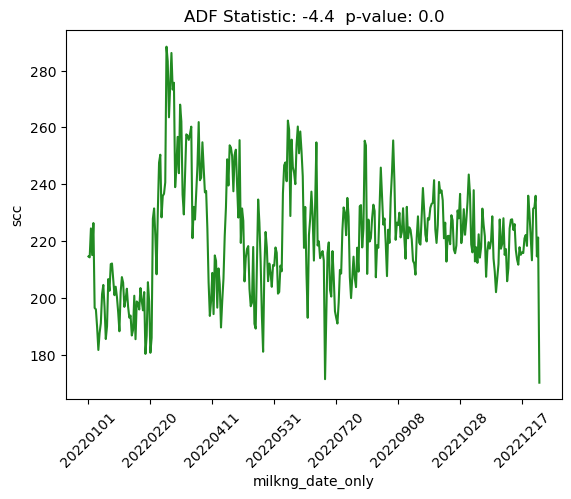

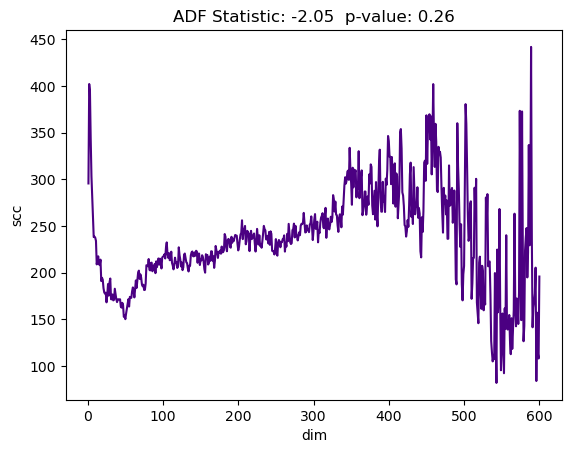

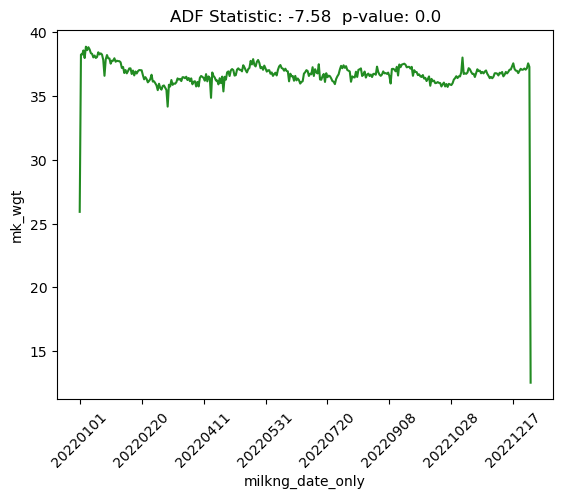

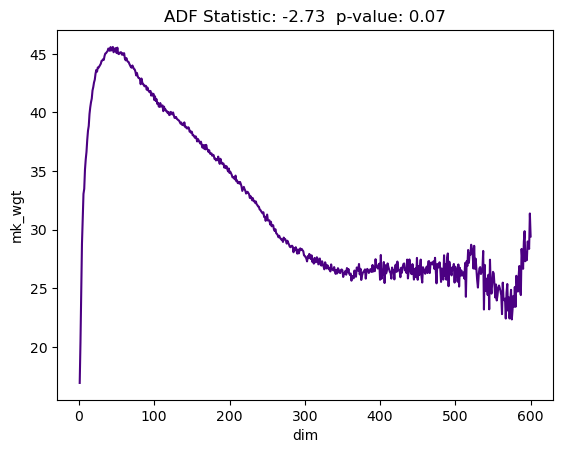

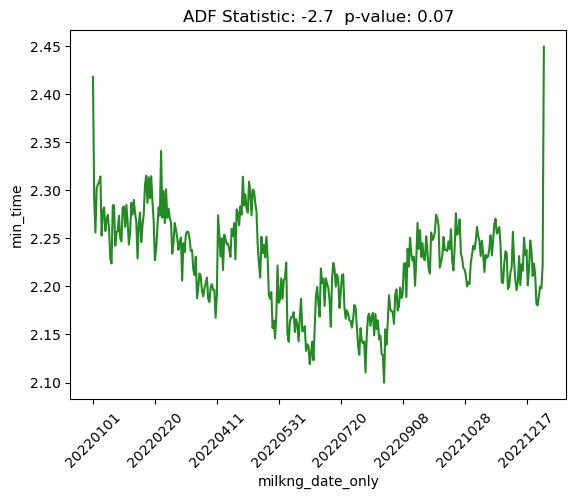

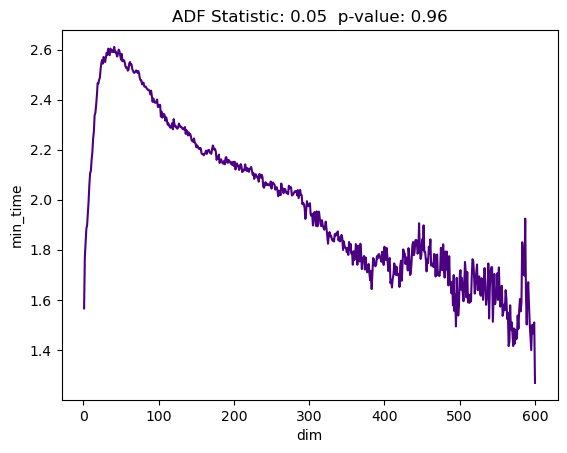

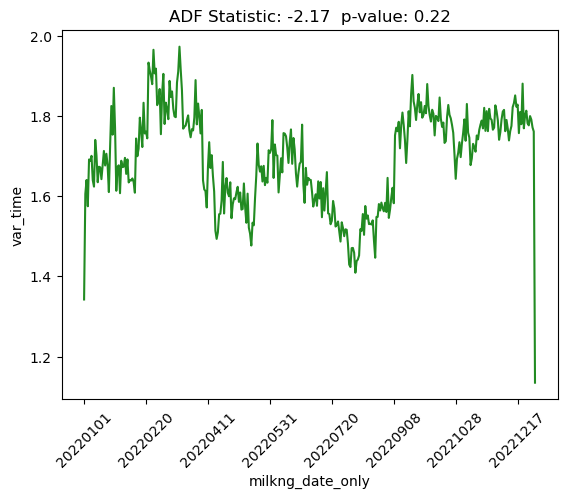

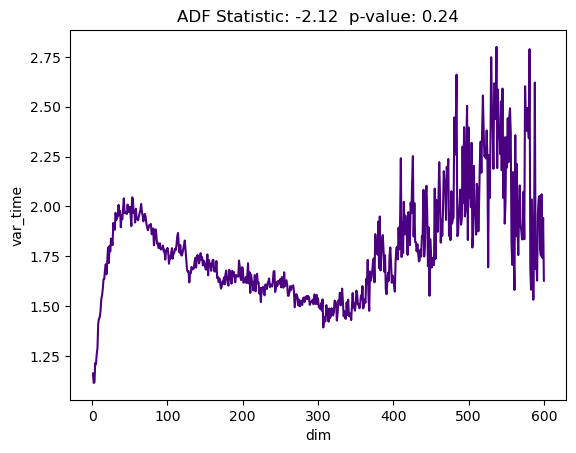

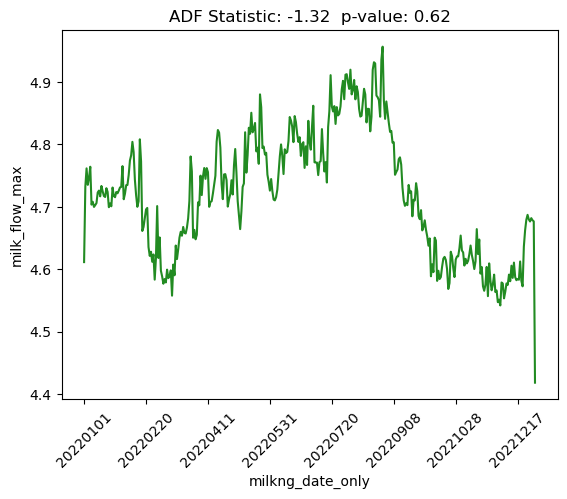

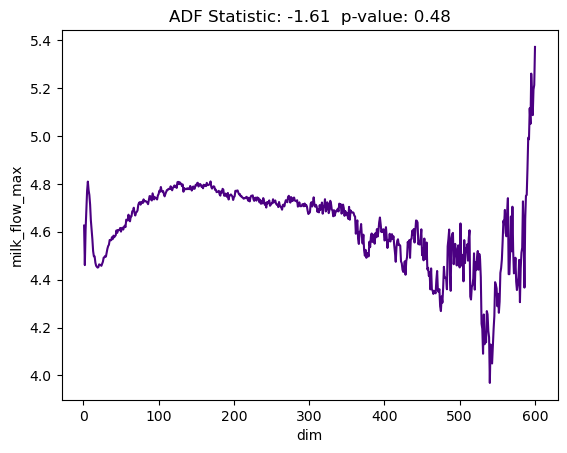

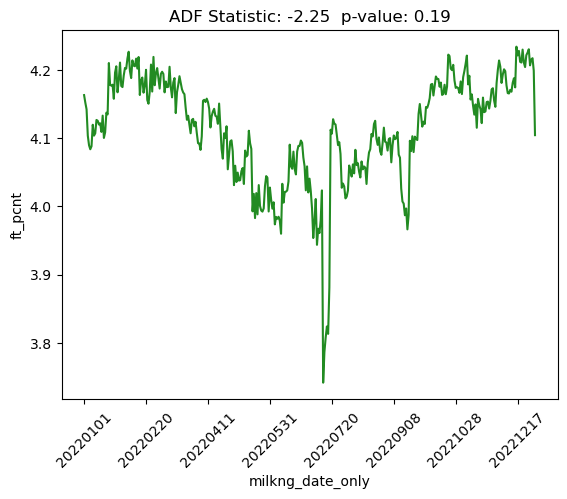

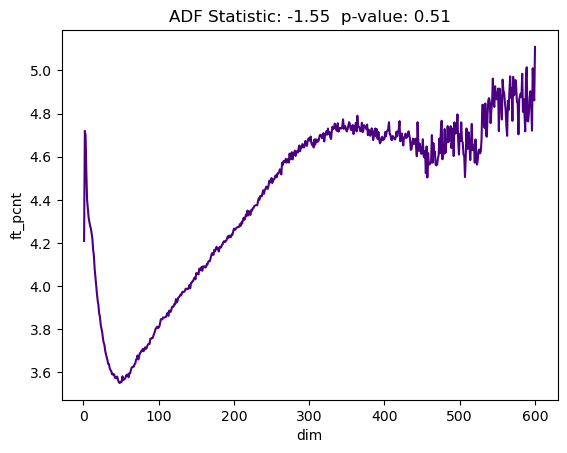

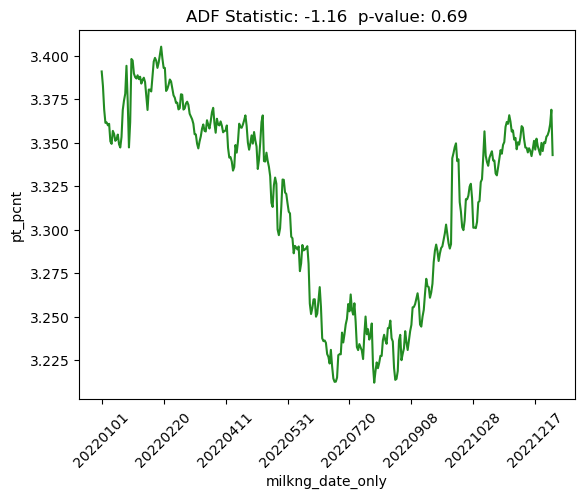

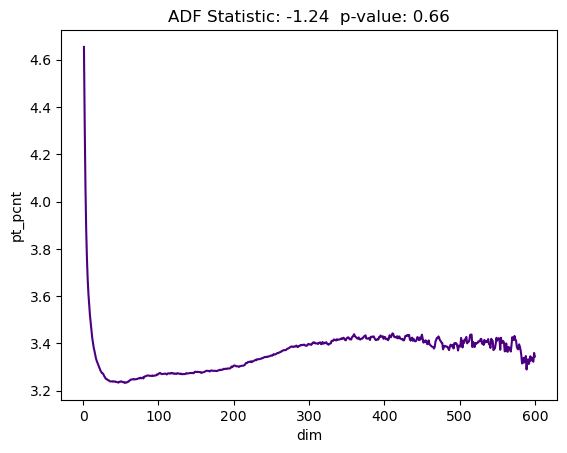

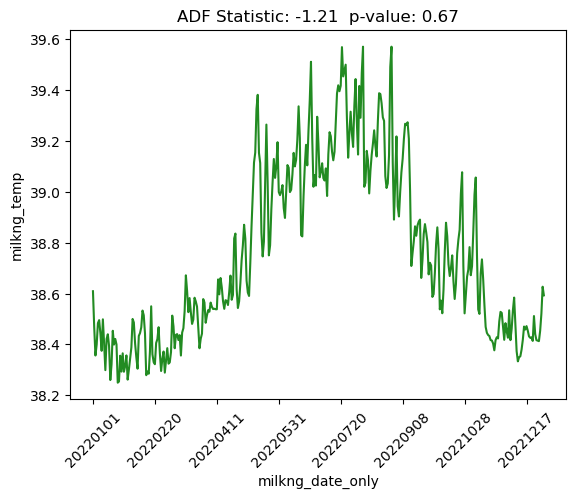

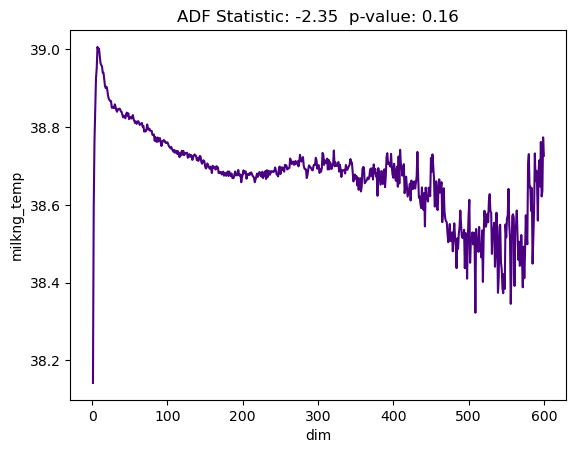

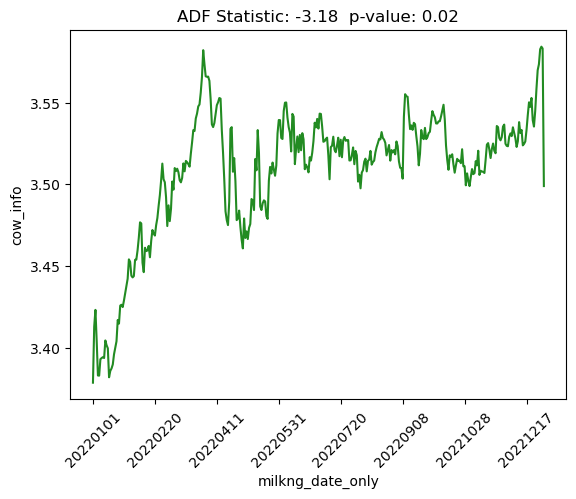

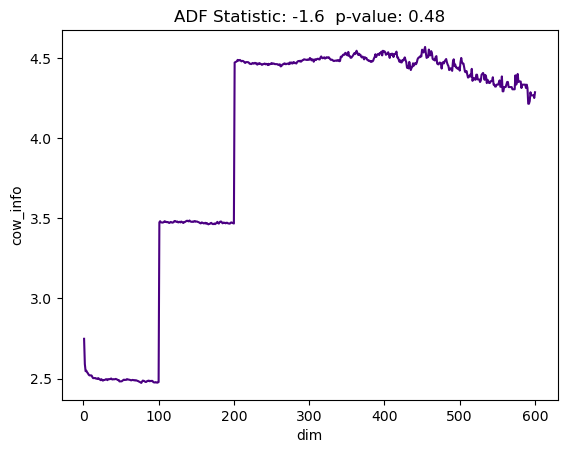

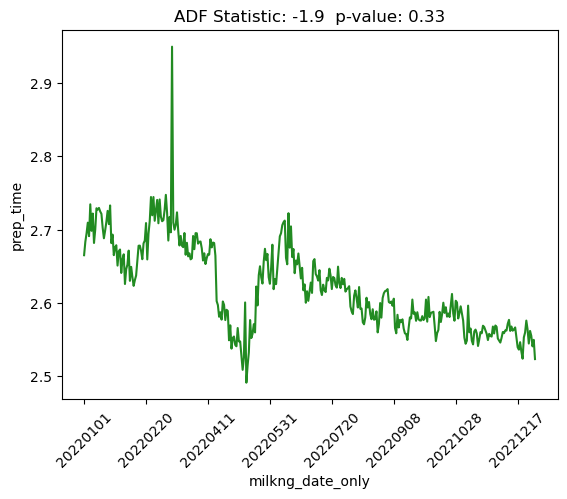

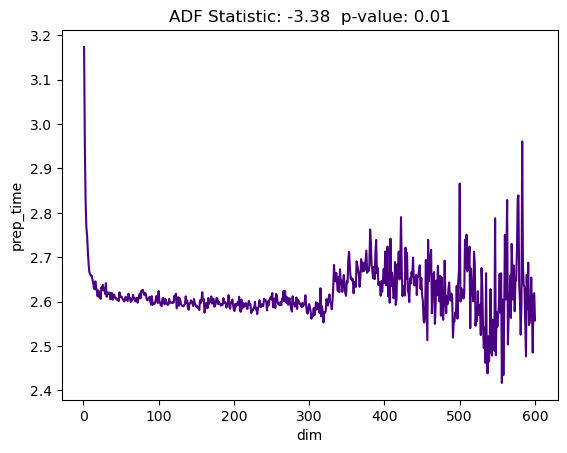

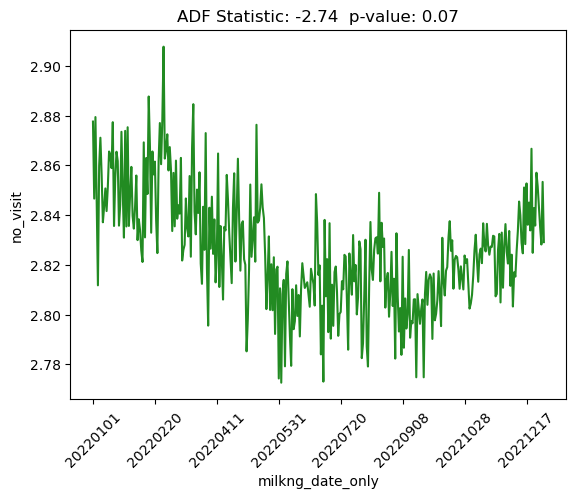

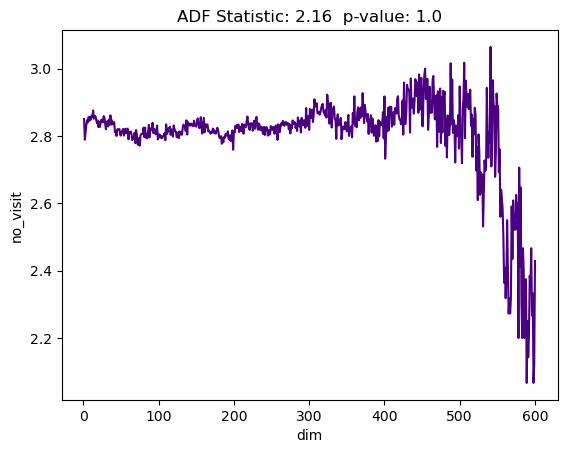

In [39]:
print("For each variable, plot with dim and date to visualize the trend")
# the variable list 
var_list = ["scc", "mk_wgt", "min_time", "var_time", "milk_flow_max", "ft_pcnt", "pt_pcnt", "milkng_temp", "cow_info", "prep_time", "no_visit"]

print("Loop through the variable list and plot")   
for var_name in var_list:
    
    
    df_plot = df.groupby('milkng_date_only').mean(numeric_only=True)[var_name]
    # ADF test
    ad_fuller_result = adfuller(df_plot)
    text = str('ADF Statistic: ' + str(round(ad_fuller_result[0], 2))) + str('  p-value: ' + str(round(ad_fuller_result[1], 2)))
    plt.title(text)
    #plt.show()
    df_plot.plot(color="forestgreen")
    plt.xticks(rotation=45)
    plt.ylabel(var_name)
    plt.show()
    print("==========")

    df_plot = df.groupby('dim').mean(numeric_only=True)[var_name]
    # ADF test
    ad_fuller_result = adfuller(df_plot)
    #plt.show()
    df_plot.plot(color="indigo")
    text = str('ADF Statistic: ' + str(round(ad_fuller_result[0], 2))) + str('  p-value: ' + str(round(ad_fuller_result[1], 2)))
    plt.title(text)
    plt.ylabel(var_name)
    plt.show()

### Chunking for time-series model

In [23]:
# 1. Given a dataset of a cow, find the start and end index of valid period (continous dim and the same period index) 

# 2. Given a valid period, chunk to X and y 

# 3. Use an overall function to loop through cows in a herd

In [19]:
# 1. Given a dataset of a cow, find the start and end index of valid period (continous dim and the same period index) 
""" 
func: 
    to find the start and end index of valid period 
args: 
    ls_dim: list[float] 
    ls_period_index: list[int] 
return: 
    ls_index: a list of start and end index of this cow: list[int]
"""
def find_valid_perod(ls_dim, ls_period_index): 
    
    # check the length of ls_dim 
    if len(ls_dim) <= 2: 
        return [0, len(ls_dim)]
        
    # init result and append the start index
    ls_index = [0]  
    
    # loop through the two input lists 
    for i in range(len(ls_dim)-1): 
        # if dim jumped or period index changed 
        if ((ls_dim[i+1] - 1) != ls_dim[i]) or (ls_period_index[i+1] != ls_period_index[i]): 
            # append new end index 
            ls_index.append(i) 
            
    # check for the last element  
    if (ls_dim[-1]-1 == ls_dim[-2]) and (ls_period_index[-1] == ls_period_index[-2]): 
        # append the last 
        ls_index.append(len(ls_dim))
        
    return ls_index
    

In [20]:
# 2. Given a valid period, chunk to X and y 
""" 
func: 
    given a valid period, create 
    dataset for seq2seq models X, y 
args: 
    valid_period: dataframe (the target (scc_std) has index 0!)
    X_len: int (length of input time period)
    y_len: int (length of output time period)
return: 
    don't return, keep appending ls_X, ls_y
"""
def chunk_to_X_y(valid_period, X_len, y_len, ls_X, ls_y):
    
    # check length 
    if valid_period.shape[0] < X_len + y_len: 
        return None

    # loop by the rows (start, end, step)
    for i in range(0, valid_period.shape[0]-X_len-y_len, y_len): 
        # append to X 
        ls_X.append(valid_period.iloc[i:i+X_len, :].to_numpy())
        # append to y 
        ls_y.append(valid_period.iloc[i+X_len:i+X_len+y_len, 0].to_numpy())
                    

In [21]:
# 3. Use an overall function to loop through cows in a herd
""" 
func: 
    loop through cows and chunking 
args: 
    df_stded: dataframe
    ls_predictors: list of variables keeped in prediction (list[str])
    X_len, y_len: the length of X and y (predictors and predicitons) (int, int)
return: 

"""
def chunk_herd(df_stded, ls_predictors):
    
    # list of cow id 
    ls_cow_id = df_stded['anm_ida'].unique().tolist() 

    # store valid_period 
    ls_df_period = []
    
    # looping cow id 
    for idx in ls_cow_id:
        
        # obtain cow data by index
        df_cow = df_stded[df_stded['anm_ida']==idx]

        """using func: """
        ls_index = find_valid_perod(df_cow['dim'].tolist(), df_cow['period_index'].tolist())

        # loop through ls_index for each valid period 
        for idx in range(len(ls_index)-1):
        
            # obtain a period from ls_index 
            valid_period = df_cow.iloc[ls_index[idx]:ls_index[idx+1], :]

            # keep only the predictor variables
            valid_period = valid_period[ls_predictors]
        
            # append to ls_df_period
            ls_df_period.append(valid_period)
            
    return ls_df_period

In [22]:
""" 
func: 
    to process a herd of data 
arg: 
    df_4: pd.Dataframe
    var_list_dim: list to correct for dim (list[str])
    var_list_date: list to correct for date (list[str])
    X_len: int
    y_len: int
    ls_predictors: list of vars keep (list[str])
    one_herd=True: boolean 
return: 
    ls_X: numpy 3d
    ls_y: numpy 2d 
    scc_mean: int
    scc_var: int
"""
def process_data_per_herd(df, var_list_dim, var_list_date, X_len, y_len, ls_predictors, one_herd=True):

    if one_herd:
        print("Put scc values in buckets to regulize regression model")
        """using func: """
        df['scc_bucket']=df['scc'].apply(conditions)
        print("check nan: ", df['scc_bucket'].isnull().sum())

    print("Correcting for dim...")
    for var_name in var_list_dim:
        # obtain the list of mean
        mean = df.groupby('dim').mean(numeric_only=True)[var_name]
        # convert to dictionary
        dict_ = mean.to_dict()
        # create new variable
        df[var_name] = df.apply(lambda x: x[var_name] - dict_[x['dim']], axis=1)

    print("Correcting for milkng_date_only...")
    for var_name in var_list_date:
        # obtain the list of mean
        mean = df.groupby('milkng_date_only').mean(numeric_only=True)[var_name]
        # convert to dictionary
        dict_ = mean.to_dict()
        # create new variable
        df[var_name] = df.apply(lambda x: x[var_name] - dict_[x['milkng_date_only']], axis=1)

    # we can pick if to standardize from here or not 
    if one_herd:
        print("Standardize SCC and storing")
        scc_var = df['scc_bucket'].std() 
        scc_mean = df['scc_bucket'].mean() 
        df["scc"] = (df['scc_bucket'] - scc_mean) / scc_var
        print("The mean and variance: ", scc_mean, scc_var)
    else: 
        scc_mean, scc_var = -1, -1
        print("Not standardizing scc per herd: ", scc_mean, scc_var)

    # standardization: except for scc where we have already stded
    for i in range(1, len(ls_predictors)): 
        df[ls_predictors[i]] = (df[ls_predictors[i]] - df[ls_predictors[i]].mean()) / df[ls_predictors[i]].std()

    """using func: """
    ls_X, ls_y = chunk_herd(df,  ls_predictors)
    
    return ls_X, ls_y, scc_mean, scc_var

# Sequence to sequence regression for each period

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional

In [38]:
# extra code – defines a utility function we'll reuse several time
"""
func: 
    fit_and_evaluate
args: 
    model: tf model
    train_set: tuple(X_train, y_train)
    valid_set: tuple(X_test, y_test)
    learning_rate: float
    epochs: int 
"""
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=100):
    
    # set the early stopping 
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=20, restore_best_weights=True)
    
    # set optimizers
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    
    # compile the model
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    
    # fitting the model 
    history = model.fit(
                    x = train_set[0], 
                    y = train_set[1],
                    batch_size=128,
                    validation_data=(valid_set[0], valid_set[1]), 
                    epochs=epochs,
                    callbacks=[early_stopping_cb])
    
    # compute the validation loss
    valid_loss, valid_mae = model.evaluate(valid_set[0], valid_set[1])
    
    return valid_mae, model, history

In [39]:
""" 
func: 
    to evaluate regression by 
    converting to classification problem 
args: 
    y_test_value: numpy (number of period, length)
    y_pred_value: numpy (number of period, length)
    scc_threshold: the scc threshold set to pick out mastitis in the predicion set 
    buffer = 5: int (the delay of mastitis occurence)
return: 
    SP, SE, AUC
"""
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
def regress_to_classify(test, pred, scc_threshold, buffer = 5): 
    
    # set result y_pred as the num of rows (example)
    y_pred = [0 for i in range(pred.shape[0])]
    y_test = [0 for i in range(pred.shape[0])]

    # loop rows 
    for i in range(pred.shape[0]): 
        one_pred = pred[i, -buffer:]
        # set 1 in y_pred base on the threshold 
        if max(one_pred) >= scc_threshold: y_pred[i] = 1
        one_test = test[i, -buffer:]
        # set 1 in y_test base on the threshold 
        if max(one_test) >= 2500: y_test[i] = 1
    
    """using sklearn"""
    try:
        # this func requie y_test to have at least two classes
        auc = roc_auc_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sp = tn / (tn + fp)
        se = tp / (tp + fn)
    except ValueError:
        print("Invalid threshold")
        sp, se, auc = 0.1, 0.1, 0.1

    print("sp, se, auc: ", sp, se, auc)
    return sp, se, auc

In [40]:
""" 
func: 
    define model, split train&test, and evaluate
args: 
    ls_X: numpy 3d
    ls_y: numpy 2d
    scc_mean: int
    scc_var: int
    EPOCHS: int
return: 
    y_pred_value, y_test_value: numpy 2d
    SP, SE, AUC: int
"""
def train_and_evaluate_herd(ls_X, ls_y, scc_mean, scc_var, EPOCHS, check_param=True):
    print("Define model...")
    tf.random.set_seed(42)
    ahead_model = tf.keras.Sequential([
        tf.keras.layers.Bidirectional(LSTM(X_len, input_shape=[None, len(ls_predictors)])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(y_len)
    ])

    # split into training and testing
    training_ratio = 0.8
    # split and convert to numpy array format (required by tf)
    train_set = (np.array(ls_X[:int(training_ratio*len(ls_X))]), np.array(ls_y[:int(training_ratio*len(ls_y))]))
    test_set = (np.array(ls_X[int(training_ratio*len(ls_X)):]), np.array(ls_y[int(training_ratio*len(ls_y)):]))

    print("Check length of X and y: ", len(ls_X), len(ls_y))
    print("Check length of train and test: ", len(train_set[0]), len(test_set[0]))
    print("training_ratio: ", training_ratio)

    """using func: """
    valid_mae, model, histroy = fit_and_evaluate(ahead_model, train_set, test_set, learning_rate=0.02, epochs=EPOCHS)

    if check_param:
        # model summary 
        model.summary() 
    
    print("scc_mean, scc_var: ", scc_mean, scc_var)
    print("Average error: ", scc_mean * valid_mae)

    print("Making prediction...")
    y_pred = model.predict(test_set[0])
    y_pred_value =  (y_pred * scc_var) + scc_mean
    y_test_value = (test_set[1] * scc_var) + scc_mean
    
    # select scc_threshold based on herds
    #threshold_ls = [scc_mean-0.75*scc_var, scc_mean-0.5*scc_var, scc_mean-0.25*scc_var, scc_mean, scc_mean+0.25*scc_var,  scc_mean+0.5*scc_var, scc_mean+0.75*scc_var]
    #threshold_ls = [scc_mean-0.5*scc_var, scc_mean-0.4*scc_var, scc_mean-0.3*scc_var, scc_mean-0.2*scc_var, scc_mean-0.1*scc_var, scc_mean, scc_mean+0.1*scc_var, scc_mean+0.2*scc_var,  scc_mean+0.3*scc_var, scc_mean+0.4*scc_var, scc_mean+0.5*scc_var]
    threshold_ls = [scc_mean]
    performance_ls = [0.1, 0.1, 0.1]
    # set init AUC 
    AUC_max = 0.1 
    # looping for threshold 
    for i in threshold_ls:    
        """using func: regress_to_classify"""
        SP, SE, AUC = regress_to_classify(y_test_value, y_pred_value, scc_threshold=i)
        print("SP, SE, AUC: ", SP, SE, AUC)
        # pick by AUC
        if AUC >= AUC_max:
            # append to performance
            performance_ls = [SP, SE, AUC]
            # reset AUC_max 
            AUC_max = AUC
    
    # end looping 
    print()
    print("Final SP, SE, AUC: ", performance_ls)
    
    return y_pred_value, y_test_value, SP, SE, AUC

# Combine data-processing and prediction for herds

### Training all the herds together

In [41]:
""" 
func: 
    the final function from dataframe to X, y 
args: 
    df: pd.Dataframe (raw df) 
    var_list_dim: list[str] 
    var_list_date: list[str] 
    X_len: int (input period) 
    y_len: int (output period) 
    ls_predictors: list[str]
return: 
    ls_X_ls: np.array (examples, input period, variables)
    ls_y_ls: np.array (examples, input period)
    scc_mean, scc_var: float 
"""
def process_all_herd(df, var_list_dim, var_list_date, X_len, y_len, ls_predictors):

    """using func: conditions"""
    df['scc']=df['scc'].apply(conditions)
    print("check nan: ", df['scc'].isnull().sum())

    print("Correcting for dim...")
    for var_name in var_list_dim:
        # obtain the list of mean
        mean = df.groupby('dim').mean(numeric_only=True)[var_name]
        # convert to dictionary
        dict_ = mean.to_dict()
        # create new variable
        df[var_name] = df.apply(lambda x: x[var_name] - dict_[x['dim']], axis=1)

    print("Correcting for milkng_date_only...")
    for var_name in var_list_date:
        # obtain the list of mean
        mean = df.groupby('milkng_date_only').mean(numeric_only=True)[var_name]
        # convert to dictionary
        dict_ = mean.to_dict()
        # create new variable
        df[var_name] = df.apply(lambda x: x[var_name] - dict_[x['milkng_date_only']], axis=1)

    # we can pick if to standardize from here or not
    scc_var = df['scc'].std() 
    scc_mean = df['scc'].mean() 

    # standardization:
    for i in range(len(ls_predictors)): 
        df[ls_predictors[i]] = (df[ls_predictors[i]] - df[ls_predictors[i]].mean()) / df[ls_predictors[i]].std()

    """using func: """
    ls_df_valid = chunk_herd(df,  ls_predictors)

    return ls_df_valid, scc_mean, scc_var

In [32]:
# init list with variables needed to be corrected by dim 
var_list_dim = ["mk_wgt", "min_time", "milk_flow_max", "ft_pcnt"]
# init list with variables needed to be corrected by dim 
var_list_date = ["milkng_temp"]
# a list of predictor variables: 1 target + 6 variables
ls_predictors = ["scc", "ft_pcnt", "mk_wgt", "min_time", "milk_flow_max", "milkng_temp"]
# X length is the length of input X 
X_len = 35
# y length is the length of output y 
y_len = 8

"""using func: """
df_4 = df[df['hrd_ida']==4]
ls_df_valid, scc_mean, scc_var = process_all_herd(df_4, var_list_dim, var_list_date, X_len, y_len, ls_predictors)

check nan:  0
Correcting for dim...
Correcting for milkng_date_only...


In [33]:

ls_X, ls_y = [], [] 
for i in range(len(ls_df_valid)): 
    valid_period = ls_df_valid[i]
    """using func: """
    chunk_to_X_y(valid_period, X_len, y_len, ls_X, ls_y)

In [42]:
"""using func: train_and_evaluate_herd"""
_, _, SP, SE, AUC = train_and_evaluate_herd(ls_X, ls_y, scc_mean, scc_var, EPOCHS=1)


Define model...
Check length of X and y:  2957 2957
Check length of train and test:  2365 592
training_ratio:  0.8
19/19 [==============================] - 0s 7ms/step - loss: 0.2125 - mae: 0.4417
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirecti  (None, 70)                11760     
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 70)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 568       
                                                                 
Total params: 12328 (48.16 KB)
Trainable params: 12328 (48.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
scc_mean, scc_var: 

# Experimenting

In [30]:



# init result_ls 
result_ls = [] 
# X length is the length of input X, y length is the length of output y 
ls_X_len_y_len = [(21, 5), (28, 5), (35, 5), (21, 8), (28, 8), (35, 8), (21, 10), (28, 10), (35, 10)]

for pair in ls_X_len_y_len:
    X_len, y_len = pair[0], pair[1]
    print("========================================")
    print("X_len, y_len: ", X_len, y_len)
    
    # init X, y
    ls_X, ls_y = [], [] 
    # looping ls_df_valid (list[df])
    for i in range(len(ls_df_valid)): 
        # obtain period
        valid_period = ls_df_valid[i]
        """using func: """
        chunk_to_X_y(valid_period, X_len, y_len, ls_X, ls_y)
        
    # here 
    """using func: train_and_evaluate_herd"""
    _, _, SP, SE, AUC = train_and_evaluate_herd(ls_X, ls_y, scc_mean, scc_var, EPOCHS=10)
    result_ls.append([SP, SE, AUC])
        
print(result_ls)

X_len, y_len:  21 5
Define model...
Check length of X and y:  81403 81403
Check length of train and test:  65122 16281
training_ratio:  0.8
Epoch 1/10
509/509 [==============================] - 17s 22ms/step - loss: 0.1896 - mae: 0.3716 - val_loss: 0.1768 - val_mae: 0.3276
Epoch 2/10
509/509 [==============================] - 9s 17ms/step - loss: 0.1666 - mae: 0.3264 - val_loss: 0.1662 - val_mae: 0.3133
Epoch 3/10
509/509 [==============================] - 10s 19ms/step - loss: 0.1613 - mae: 0.3141 - val_loss: 0.1610 - val_mae: 0.3037
Epoch 4/10
509/509 [==============================] - 9s 19ms/step - loss: 0.1584 - mae: 0.3076 - val_loss: 0.1585 - val_mae: 0.2963
Epoch 5/10
509/509 [==============================] - 11s 21ms/step - loss: 0.1570 - mae: 0.3042 - val_loss: 0.1571 - val_mae: 0.2977
Epoch 6/10
509/509 [==============================] - 11s 22ms/step - loss: 0.1562 - mae: 0.3017 - val_loss: 0.1569 - val_mae: 0.3050
Epoch 7/10
509/509 [==============================] - 10s 

Epoch 3/10
175/175 [==============================] - 8s 47ms/step - loss: 0.1821 - mae: 0.3517 - val_loss: 0.1805 - val_mae: 0.3360
Epoch 4/10
175/175 [==============================] - 8s 45ms/step - loss: 0.1780 - mae: 0.3438 - val_loss: 0.1762 - val_mae: 0.3250
Epoch 5/10
175/175 [==============================] - 8s 44ms/step - loss: 0.1753 - mae: 0.3379 - val_loss: 0.1726 - val_mae: 0.3218
Epoch 6/10
175/175 [==============================] - 8s 45ms/step - loss: 0.1728 - mae: 0.3329 - val_loss: 0.1694 - val_mae: 0.3219
Epoch 7/10
175/175 [==============================] - 8s 46ms/step - loss: 0.1708 - mae: 0.3294 - val_loss: 0.1663 - val_mae: 0.3137
Epoch 8/10
175/175 [==============================] - 8s 46ms/step - loss: 0.1690 - mae: 0.3259 - val_loss: 0.1640 - val_mae: 0.3110
Epoch 9/10
175/175 [==============================] - 8s 44ms/step - loss: 0.1675 - mae: 0.3234 - val_loss: 0.1625 - val_mae: 0.3066
Epoch 10/10
175/175 [==============================] - 1s 7ms/step - 

In [1]:
result_ls = [[0.8500522466039707, 0.8307533539731682, 0.8404028002885694], [0.8536213080973822, 0.841596130592503, 0.8476087193449425], [0.8527284093953738, 0.851528384279476, 0.8521283968374248], [0.8526372443487621, 0.801038062283737, 0.8268376533162496], [0.8577384712571068, 0.8106995884773662, 0.8342190298672365], [0.8576940198842559, 0.8117647058823529, 0.8347293628833045], [0.8514412416851441, 0.7930283224400871, 0.8222347820626157], [0.8393574297188755, 0.8121827411167513, 0.8257700854178134], [0.8490995260663508, 0.8380952380952381, 0.8435973820807945]]

### Plot the results 

In [6]:
""" 
func: 
    to write the label on plots 
args: 
    dates, temp: list of x and y in the plot 
    plt: the plot object
return: 
    annotated plot
"""
import matplotlib.pyplot as plt
import numpy as np
def write_label(dates, temp, plt): 
    for x, y in zip(dates, temp):
        label = y
        plt.annotate(label, (x, y),
                     xycoords="data",
                     textcoords="offset points",
                     xytext=(0, 10), ha="center")

""" 
func: 
    to plot for a model's result 
args: 
    log_ls: list[list[float]] the results of this model
    model_name: str
    path: str
return: 
    name_ls: list[str]
"""
def plot_one_model(log_ls, model_name, path):
    
    from matplotlib.pyplot import figure



    # init methods
    method_str = [' 21 days', ' 28 days', '35 days']
    # init method id (0, 1, 2)
    idx_method_ls = [0, 1, 2]
    # total num of methods
    shrink_method = 3 
    # init name 
    name_ls = []

    # looping for idx_method 
    for idx_method in idx_method_ls: 

        # init list for SP, SE, AUC 
        SP, SE, AUC = [], [], [] 

        # loop the list 
        for i in range(idx_method, len(log_ls), shrink_method):
            # specificity
            sp = round(log_ls[i][0]*100, 2)
            SP.append(sp)
            # sensitifity
            se = round(log_ls[i][1]*100, 2)
            SE.append(se)
            # auc
            auc = round(log_ls[i][2]*100, 2)
            AUC.append(auc)   

        # reserse the list
        SP, SE, AUC = SP[::-1], SE[::-1], AUC[::-1]
        x_axis = ['5 days', '3 days', '1 days']

        plt.plot(x_axis, SP, label = 'specificity', color="indigo", marker = 'o')
        """using func: """
        write_label(x_axis, SP, plt)
        plt.plot(x_axis, SE, label = 'sensitivity', color="indigo", marker = 's')
        """using func: """
        write_label(x_axis, SE, plt)
        plt.plot(x_axis, AUC, label = 'AUC', color="forestgreen", marker = '^')
        """using func: """
        write_label(x_axis, AUC, plt)
        plt.legend() 
        plt.title(model_name + " with input length: " + method_str[idx_method])
        plt.xlabel("Days before the threshold")
        
        # saving 
        name = model_name + "_" + method_str[idx_method]
        name_ls.append(name)
        plt.gcf().set_size_inches(5, 5)
        plt.savefig(path+name, dpi=200)
        plt.close()
        
    return name_ls


In [7]:
name_ls = plot_one_model(result_ls, 'LSTM', 'plot/Results_regression_new/')

In [8]:
""" 
func: 
    concate plots 
args: 
    name_ls_log, name_ls_tree, name_ls_mlp: list[str]
return: 
    a plot
"""
def concat_plots(name_ls, path):
    
    temp = name_ls
    figa = plt.imread(path + temp[0] + '.png')
    figb = plt.imread(path + temp[1] + '.png')
    figc = plt.imread(path + temp[2] + '.png')
    figd = np.concatenate((figa,figb), axis=0)
    fige = np.concatenate((figd,figc), axis=0) 
                   
    fname = path + "bi_lstm_longer" + ".png"
    plt.imsave(fname, fige)

In [9]:
concat_plots(name_ls, 'plot/Results_regression_new/')